In [5]:
%matplotlib inline

In [590]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import pandas_datareader.data as web


def read_csv_data(file, symbol_name):
    # df.datetime(2017,1,1)
    df_temp = pd.read_csv(file, index_col='Date', parse_dates=True,
                          usecols=['Date', 'Adj Close'], na_values=['nan'])
    df_temp = df_temp.rename(columns={'Adj Close': symbol_name})
    df_temp.index.name = None
    df_temp = df_temp.iloc[::-1]
    return df_temp

def filter_dates(df_temp, start_date, end_date):
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    df = df.join(df_temp) # left join
    return df

def get_data_online(symbol, start_date = None, end_date = None):
    df = pdr.get_data_yahoo(symbol, start_date, end_date)
    df = df.loc[:,['Adj Close']]
    df = df.rename(columns={'Adj Close' : symbol})
    return df

def get_datas_online(symbols, start_date = None, end_date = None, add_ref = True):
    df = get_data_online(symbols[0], start_date, end_date) \
        if not add_ref else get_data_online('SPY',start_date, end_date)
    for sym in (symbols[1:] if not add_ref else symbols):
        df_temp = get_data_online(sym, start_date, end_date)
        df = df.join(df_temp)
    return df

def get_and_save_to_csv(symbol, start_date = None, end_date = None):
    df = pdr.get_data_yahoo(symbol, start_date, end_date)
    df.to_csv('./data/'+symbol+'.csv')
    return df

def fill_na(df):
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

def plot_data(df, title="Stock", xlabel="Date", ylabel="Price"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return ax
    
def compute_daily_return(df):
    daily_return = (df[1:]/df[:-1].values) - 1
    return daily_return

def compute_numpy_std(df):
    std = np.std(df, dtype=np.float64, ddof=1)
    return std

def compute_sharp_ratio(returns, sample_per_year=252):
    # daily_returns or weekly ...
    sr = math.sqrt(sample_per_year) * returns.mean() / returns.std()
    return sr

def compute_cumulative_return(df):
    cr = df[:-1]/df.ix[0] - 1
    return cr

def compute_portfolio_value(prices, allocs, start_value=1, accumu_ret=False):
    #prices = dfs.as_matrix() # convert to numpy matrix
    normed = prices / prices.ix[0]
    accumu_change = allocs * normed
    if not accumu_ret:
        pos_vals = accumu_change * start_value
    else:
        pos_vals = accumu_change
    port_vals = pos_vals.sum(axis=1)
    return port_vals

def compute_rolling_mean(df, window_size=20):
    rm = df.rolling(window_size).mean()
    return rm

def append_to_plot(df, ax, label=''):
    df.plot(label=label, ax=ax)
    ax.legend(loc='upper left')
    #plt.show()

def plot_scatter(df, x_name, y_name):
    ax = df.plot(kind='scatter', x=x_name, y=y_name)
    return ax
    
def compute_correlation(df):
    return df.corr(method='pearson')
    
def fit_line(dfx, dfy, degree=1, plot=True):
    coef = np.polyfit(dfx, dfy, degree)
    if plot:
        plt.plot(dfx, np.polyval(coef, dfx), '-', color='r')
    return coef # beta & alpha for degree 1

def compute_portfolio_sr(port_df, allocs):
    port_v = compute_portfolio_value(port_df, allocs)
    daily_r = compute_daily_return(port_v)
    sr = compute_sharp_ratio(daily_r)
    return sr
    
import scipy.optimize as spo
import math
def init_random(size):
    #init = np.float32([1.0/size]*size)
    init = np.random.uniform(0,1.0,(size,))
    return init

def optimize_portfolio(port_df):
    # optimize the sharp ratio to be the largest
    size = port_df.shape[1]
    x_guess = init_random(size)
    def f(allocs, port_df):
        return -compute_portfolio_sr(port_df, allocs)
    
    res = spo.minimize(f, x_guess, args=(port_df,), 
                       constraints = [{'type':'eq', 'fun':lambda x: 1-sum(x)}],
                       bounds = [(0,1.0)]*size,
                       method='SLSQP', options={'disp':True})
    return res

In [494]:
def marketsim(orders:pd.DataFrame, start_val) -> pd.DataFrame:
    '''
    @type orders: pd.DataFrame
    '''
    assert(type(orders) is pd.DataFrame)
    orders = orders.sort_index()
    syms = orders['Symbol'].drop_duplicates()
    sd = orders.index.values[0] 
    ed = orders.index.values[-1]
    # only for trading dates
    dates = get_data_online('SPY', sd, ed).index
    prices = get_datas_online(syms, sd, ed, add_ref=False)
    cash = start_val
    
    # build portfolio
    cols = syms
    cols['Cash'] = 'Cash'
    cols['Value'] = 'Value'
    portfolio = pd.DataFrame(index=dates, columns=cols).fillna(value=0.0)
    portfolio['Cash'].iloc[0] = cash # init cash
    
    # go through each date
    #leverage = (sum(abs(all stock positions))) / (sum(all stock positions) + cash)
    for datei in range(0, len(dates)):
        if datei > 0:
            portfolio.iloc[datei] = portfolio.iloc[datei-1]
            
        date = portfolio.index[datei]

        if date in orders.index:
            rows = orders.ix[date,:]
            dim = len(rows.shape)
            if dim == 1:
                symbol = rows[0]
                action = rows[1]
                share = rows[2]
                if action == 'SELL':
                    share = -share
                cash_spent = share * prices[symbol][date]
                portfolio[symbol][date] += share
                cash -= cash_spent
            else:
                for row in rows.itertuples():
                    symbol = row[1]
                    action = row[2]
                    share = row[3]
                    if action == 'SELL':
                        share = -share
                    cash_spent = share * prices[symbol][date]
                    portfolio[symbol][date] += share
                    cash -= cash_spent

        # update portfolio value
        portfolio['Cash'][date] = cash
        value = cash
        for sym, share in portfolio.ix[date, 0:-2].iteritems():
            value += prices[sym][date] * share
        portfolio['Value'][date] = value
        
    return portfolio

In [426]:
orders = pd.read_csv('./orders/orders.csv', index_col='Date',
                     parse_dates=True, na_values=['nan'])
orders.sort_index()

,Symbol,Order,Shares
Date,,,
2011-01-10,AAPL,BUY,1500
2011-01-13,AAPL,SELL,1500
2011-01-13,IBM,BUY,4000
2011-01-26,GOOG,BUY,1000
2011-02-02,XOM,SELL,4000
2011-02-10,XOM,BUY,4000
2011-03-03,GOOG,SELL,1000
2011-03-03,IBM,SELL,2200
2011-05-03,IBM,BUY,1500


In [496]:
marketsim(orders, 1000000)

Symbol,AAPL,IBM,GOOG,XOM,Cash,Value
Date,,,,,,
2011-01-10,1500.0,0.0,0.0,0.0,9.334485e+05,1.000000e+06
2011-01-11,1500.0,0.0,0.0,0.0,9.334485e+05,9.998426e+05
2011-01-12,1500.0,0.0,0.0,0.0,9.334485e+05,1.000383e+06
2011-01-13,0.0,4000.0,0.0,0.0,4.903521e+05,1.000628e+06
2011-01-14,0.0,4000.0,0.0,0.0,4.903521e+05,1.004674e+06
2011-01-18,0.0,4000.0,0.0,0.0,4.903521e+05,1.006902e+06
2011-01-19,0.0,4000.0,0.0,0.0,4.903521e+05,1.024184e+06
2011-01-20,0.0,4000.0,0.0,0.0,4.903521e+05,1.024561e+06
2011-01-21,0.0,4000.0,0.0,0.0,4.903521e+05,1.023532e+06


In [404]:
xx = port_df['MSFT']
xx['Cash'] = 'Cash'
t = xx.index[0] #+ dt.timedelta(days=10000)
port_df.ix[t, 'MSFT']

49.31305

In [579]:
port_df = get_datas_online(['AAPL', 'MSFT', 'GOOG', 'ZEM.TO', 'AMZN'], start_date=dt.datetime(2016,5,1), add_ref=False)

In [546]:
port_df.head()

,AAPL,ZEM.TO
Date,,
2016-05-02,91.701408,14.645903
2016-05-03,93.209527,14.547740
2016-05-04,92.240024,14.429945
2016-05-05,91.865625,14.429945
2016-05-06,91.353293,14.498659


In [531]:
zem = get_data_online('ZEM.TO', '2016-05-01')

In [537]:
zem = fill_na(zem)

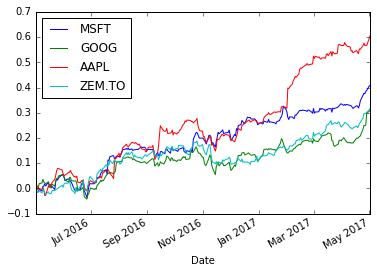

In [539]:
compute_cumulative_return(fill_na(port_df.join(zem))).plot()

In [544]:
compute_sharp_ratio(compute_daily_return(port_df.join(zem)))

MSFT      2.121998
GOOG      1.909082
AAPL      2.728815
ZEM.TO    2.123830
dtype: float64

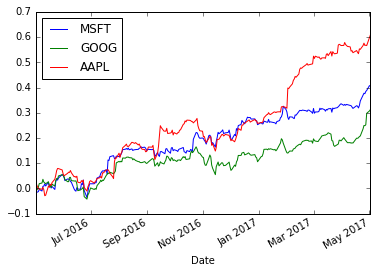

In [367]:
compute_cumulative_return(port_df).plot()

In [569]:
compute_portfolio_sr(port_df, [0.4, 0.6, 0.01])

1.2981239280832542

In [585]:
optimize_portfolio(port_df)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3.0638337192709075
            Iterations: 6
            Function evaluations: 47
            Gradient evaluations: 6


     fun: -3.0638337192709075
     jac: array([-0.00055653,  0.00093976, -0.00042108, -0.00127053,  0.00032517,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 47
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([  5.97483746e-01,   3.40256798e-01,   5.16472716e-04,
         3.82939626e-03,   5.79135871e-02])

In [348]:
compute_portfolio_sr(port_df, [0.3, 0.7, 0, 0.1])

3.010266171223217

In [167]:
x_guess = np.float32([0.1]*4)
print(x_guess)

[ 0.1  0.1  0.1  0.1]


In [164]:
np.poly1d(np.ones(4))

poly1d([ 1.,  1.,  1.,  1.])

In [592]:
dfs = get_datas_online(['AAPL'], '2016-05-01')
dfs.head()

,SPY,AAPL
Date,,
2016-05-02,203.761554,91.701408
2016-05-03,201.988184,93.209527
2016-05-04,200.861446,92.240024
2016-05-05,200.822262,91.865625
2016-05-06,201.557085,91.353293


array([   1.3694612 , -184.77269215])

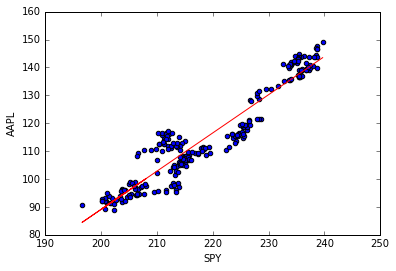

In [597]:
ax = plot_scatter(dfs, 'SPY', 'AAPL')
fit_line(dfs['SPY'], dfs['AAPL'], 1)

In [595]:
compute_correlation(dfs).iloc[0,1]

0.94472363952267457

In [82]:
dfs.to_csv('./data/msft_spy.csv')

In [ ]:
dfs = pd.read_csv('./data/msft_spy.csv', index_col='Date', parse_dates=True)

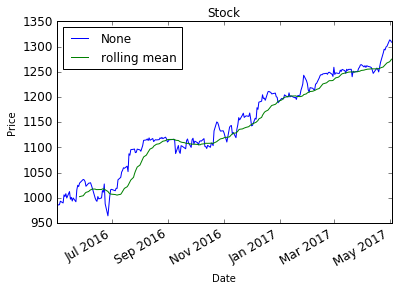

In [119]:
port = compute_portfolio_value(dfs, [0.4, 0.6], 1000)
ax = plot_data(port)
rm = compute_rolling_mean(port, 20)
append_to_plot(rm, ax, label='rolling mean')

In [76]:
df = read_csv_data('./data/SPY.csv', 'spy')
df.head()

,Adj Close
2016-05-03,201.988184
2016-05-04,200.861446
2016-05-05,200.822262
2016-05-06,201.557085
2016-05-09,201.723643


In [60]:
df2 = filter_dates(df, dt.datetime(2016,5,1), dt.datetime(2017,5,1))
df2.head()

,Adj Close
2016-05-01,NaN
2016-05-02,NaN
2016-05-03,201.988184
2016-05-04,200.861446
2016-05-05,200.822262


In [81]:
dftest = pd.read_csv('./data/spy.csv')
dftest.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2017-05-02,238.839996,238.979996,238.300003,238.770004,55117300,238.770004
1,2017-05-01,238.679993,239.169998,238.199997,238.679993,50959200,238.679993
2,2017-04-28,238.899994,238.929993,237.929993,238.080002,53247400,238.080002
3,2017-04-27,238.770004,238.949997,237.979996,238.600006,52840500,238.600006
4,2017-04-26,238.509995,239.529999,238.350006,238.399994,82714900,238.399994


In [98]:
dir(pdr.get_data_yahoo)
print(pdr.get_data_yahoo.__code__)

<code object get_data_yahoo at 0x10fb31930, file "/Users/herbert/anaconda/lib/python3.5/site-packages/pandas_datareader/data.py", line 39>


In [51]:
df = get_data_online('MSFT', dt.datetime(2016,4,30), dt.datetime(2017,5,1))
df.head()

,MSFT
Date,
2016-05-02,49.313050
2016-05-03,48.504319
2016-05-04,48.592012
2016-05-05,48.660218
2016-05-06,49.098687


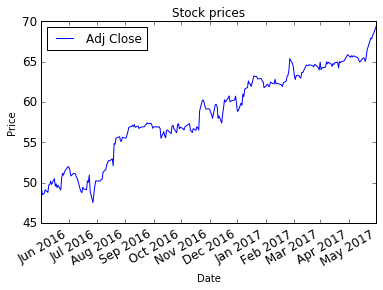

In [8]:
plot_price_data(df)

In [106]:
get_and_save_to_csv('MSFT')

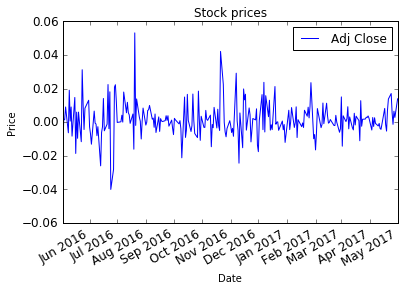

In [42]:
dr = compute_daily_return(df)
plot_data(dr)

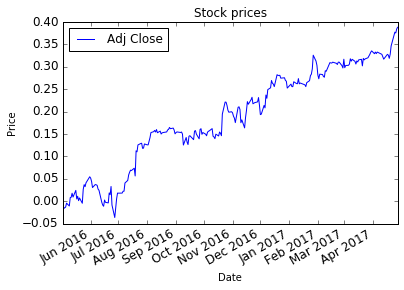

In [44]:
cr = compute_cumulative_return(df)
plot_data(cr)

In [50]:
cr.as_matrix()

array([[ 0.        ],
       [-0.01639994],
       [-0.01462165],
       [-0.01323852],
       [-0.00434698],
       [-0.01066983],
       [ 0.00810116],
       [ 0.00869393],
       [ 0.017783  ],
       [ 0.00928673],
       [ 0.02410593],
       [ 0.00500462],
       [ 0.01097383],
       [ 0.0012242 ],
       [ 0.00719333],
       [-0.004546  ],
       [ 0.02649358],
       [ 0.03703904],
       [ 0.03246271],
       [ 0.04101847],
       [ 0.05454854],
       [ 0.05156394],
       [ 0.04420201],
       [ 0.03047303],
       [ 0.03723805],
       [ 0.03664109],
       [ 0.03544731],
       [ 0.02709046],
       [ 0.02430488],
       [-0.00235729],
       [-0.00852537],
       [-0.01131102],
       [ 0.00261699],
       [-0.00255624],
       [-0.00375008],
       [ 0.01853469],
       [ 0.01455532],
       [ 0.03286065],
       [-0.00852537],
       [-0.03638138],
       [-0.0162853 ],
       [ 0.0056016 ],
       [ 0.01813674],
       [ 0.01793781],
       [ 0.01813674],
       [ 0